<a href="https://colab.research.google.com/github/shreejitp/Machine-Learning/blob/master/Regression_House_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

#train = pd.read_csv('../input/train.csv')
#test = pd.read_csv('../input/test.csv')
#full_data = train.drop(columns = 'SalePrice').merge(test, how = 'outer').drop(columns = 'Id')

ALGORITHMS USED 
- RIDGE
- LASSO
- ELASTIC NET 

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
#In this notebook I will clean, analyze, and build predictive regression models on the Ames housing dataset. Some notebooks I found helpful were:

#https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing
#https://www.kaggle.com/msieviec/housing-prices-and-regression-modeling-an-exercis

#Stacked Regressions to predict House Prices by Serigne
#COMPREHENSIVE DATA EXPLORATION WITH PYTHON by Pedro Marcelino
#A study on Regression applied to the Ames dataset by Julien Cohen-Solal

In [0]:
import pandas as pd
import io
train = pd.read_csv(io.BytesIO(uploaded['train_housing.csv']))


In [0]:
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [0]:
full_data = train.drop(columns = 'SalePrice').merge(test, how = 'outer').drop(columns = 'Id')

In [0]:
full_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [0]:
# missing values
full_data.isnull().sum()[full_data.isnull().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

We see there are quite a few missing values. According to the documentation, this actually isn't something to be too worried about as NA is a valid entry for many of the variables. Additionally, many of them seem to be related (e.g. GarageQual and GarageCond) and as such probably indicate missing values in a single row.

However, we do want to get this data reasonably clean before we start visualizing relationships as there are so many missing points. Luckily, some of the missing values will be fairly easy to deal with. First, we will treat empty values in optional features (those non-essential to a house like a pool) as simply being absent. This constitutes assigning 'NA' to ordinal or categorical data and '0' to continuous or discrete

In [0]:
# fill NA and 0
to_na = ['Alley', 
         'MasVnrType', 
         'BsmtQual', 
         'BsmtCond', 
         'BsmtExposure', 
         'BsmtFinType1', 
         'BsmtFinType2', 
         'FireplaceQu', 
         'GarageType', 
         'GarageFinish', 
         'GarageQual', 
         'GarageCond', 
         'PoolQC', 
         'Fence',
         'MiscFeature']
to_zero = ['MasVnrArea',
           'BsmtFinSF1',
           'BsmtFinSF2',
           'BsmtUnfSF',
           'TotalBsmtSF',
           'BsmtFullBath',
           'BsmtHalfBath'
           'GarageYrBlt']
to_zero = dict.fromkeys(to_zero, 0)
to_fill = dict.fromkeys(to_na, 'NA')
to_fill.update(to_zero)
full_data = full_data.fillna(value = to_fill)

Next, missing essential features (e.g. Utilities) will be filled, first with the means for each class as grouped by their neighborhood for continuous data, and then the same for modes for discrete and ordinal data as the counts are so small

In [0]:
# fill means
full_data.LotFrontage = full_data.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
full_data.MSZoning = full_data.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.value_counts()[0]))

# fill modes
list_nulls = list(full_data.isnull().sum()[full_data.isnull().sum() > 0].index)
full_data[list_nulls] = full_data.groupby(['Neighborhood'])[list_nulls].transform(lambda x: x.fillna(x.value_counts().index[0]))

Converting months from numerical to categorical

In [0]:
to_months = dict(zip([x for x in range(1,13)],
                      ['January', 'February', 
                      'March', 'April', 'May', 
                      'June', 'July', 'August', 
                      'September', 'October', 
                      'November', 'December'],))
full_data['MoSold'] = full_data['MoSold'].map(to_months)

#New Variables

We will add new variables: TotalSF, HouseAge, and RemodAge. TotalSF indicates the sum of each of the basement, first floor, and second floor square-footage of the homes as price per square-foot is a common metric in home shopping. HouseAge and RemodAge are both attempts at making the year data more useful. I considered the question, "Will it be more important that a house was built in X year or that it was Y years old at the time it was sold?" I figured the latter to be the way to go. These variables led to some negative values, but people do buy land and pay to have their houses built, so I wasn't concerned.

Here, we also drop GarageYrBlt as it proved more difficult to work with in a similar manner (because of the missing values) and I find it easy to imagine that whatever way it could have affected SalePrice was either insubstantial or not already explained by some other variables


In [0]:
# add new variables
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF']+ full_data['2ndFlrSF']
full_data['HouseAge'] = full_data['YrSold'] - full_data['YearBuilt']
full_data['RemodAge'] = full_data['YrSold'] - full_data['YearRemodAdd']

# drop old and GarageYrBlt
full_data = full_data.drop(columns = ['YrSold', 'YearRemodAdd', 
                                      'YearBuilt', 'GarageYrBlt'])

#Correlation and Outliers

We're at a point where we should easily be able to explore correlations between SalePrice and the rest of our numerical variables. We want to do this now as there is some data that appears clearly ordinal that we will convert and treat a little differently. We have some data like this now, e.g. OverallCond, but we'll be ignoring these in our search. This is all in an effort to deal with outliers.

Looking through the data, there are plenty of them, but we're really only concerned with the ones as they relate to SalePrice the most. Linear models tend to be very sensitive to outliers. There are methods for making more robust models, but if there aren't too many "bad" data points, it's easier to just get rid of them. To find these points, we'll look at a correlation heatmap

Text(0.5, 1, 'Figure 1: Correlation Heatmap for Ames Data')

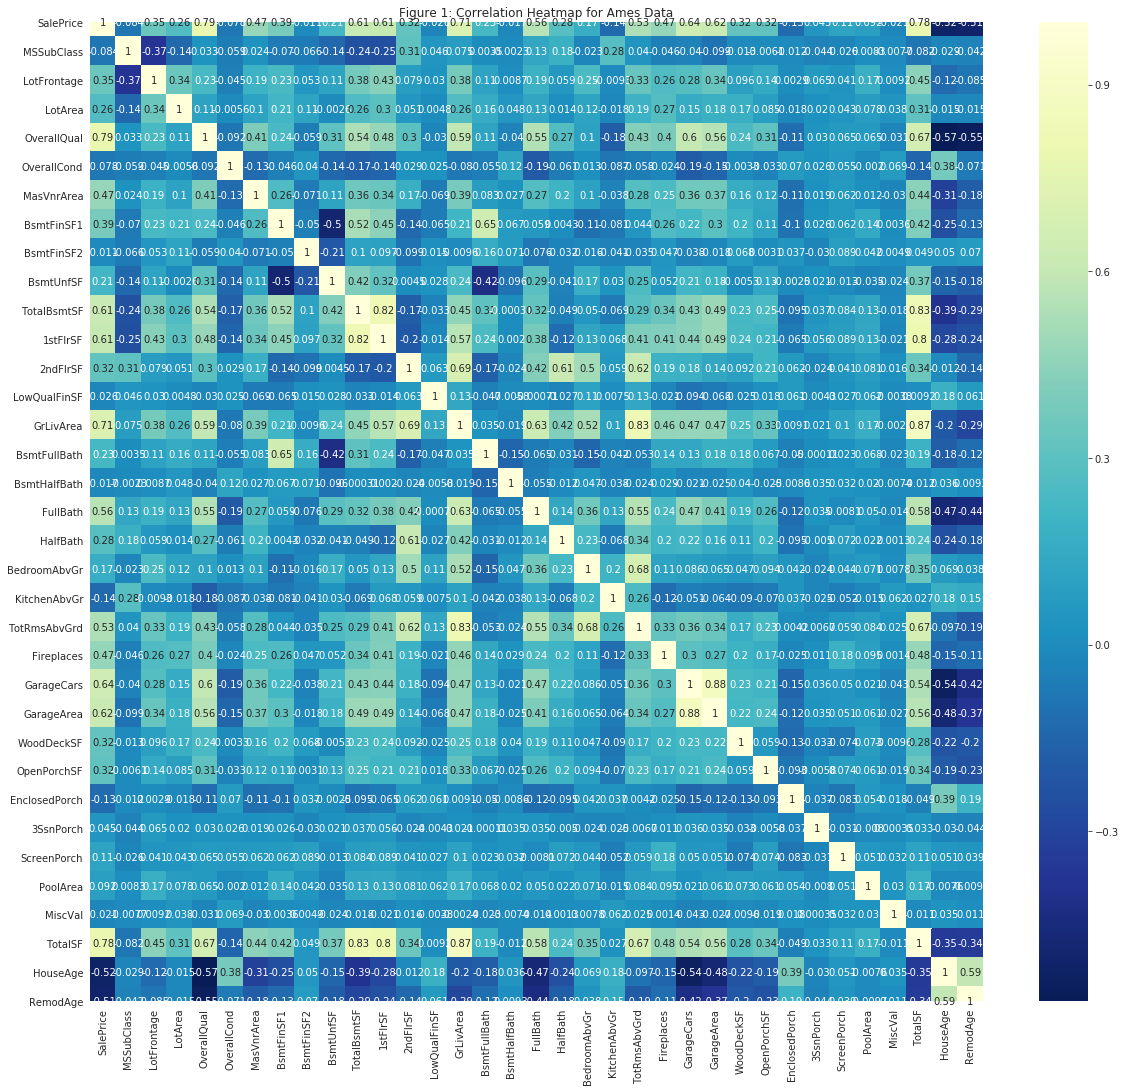

In [0]:
# correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize = (20, 18))

train_corr = full_data[full_data.dtypes[full_data.dtypes != 'object'].index]
train_corr = train_corr[:train.shape[0]]
for_pairplot = pd.concat([pd.DataFrame(train.SalePrice), train_corr], axis = 1)
train_corr = for_pairplot.corr()

sns.heatmap(train_corr, cmap = 'YlGnBu_r', annot = True).set_title('Figure 1: Correlation Heatmap for Ames Data')

This is a lot to digest, so let's reduce our list to the ten most correlated variables (by absolute value) and have a look

In [0]:
# most correlated by absolute value
most_corr = train_corr['SalePrice'].map(lambda x: abs(x)).sort_values(ascending = False)[:11].index
print(most_corr)

Index(['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'HouseAge'],
      dtype='object')


We see there is only one ordinal variable, OverallQual, so let's drop it. Let's have a look at the variables representing small, discrete quantities (e.g. rooms, cars)

In [0]:
print(full_data['GarageCars'].describe())
print(full_data['FullBath'].describe())
print(full_data['TotRmsAbvGrd'].describe())

count    2919.000000
mean        1.766358
std         0.761626
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64
count    2919.000000
mean        1.568003
std         0.552969
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: FullBath, dtype: float64
count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


Text(0.5, 0.98, 'Figure 2: Plots for SalePrice and Most Correlated Variables')

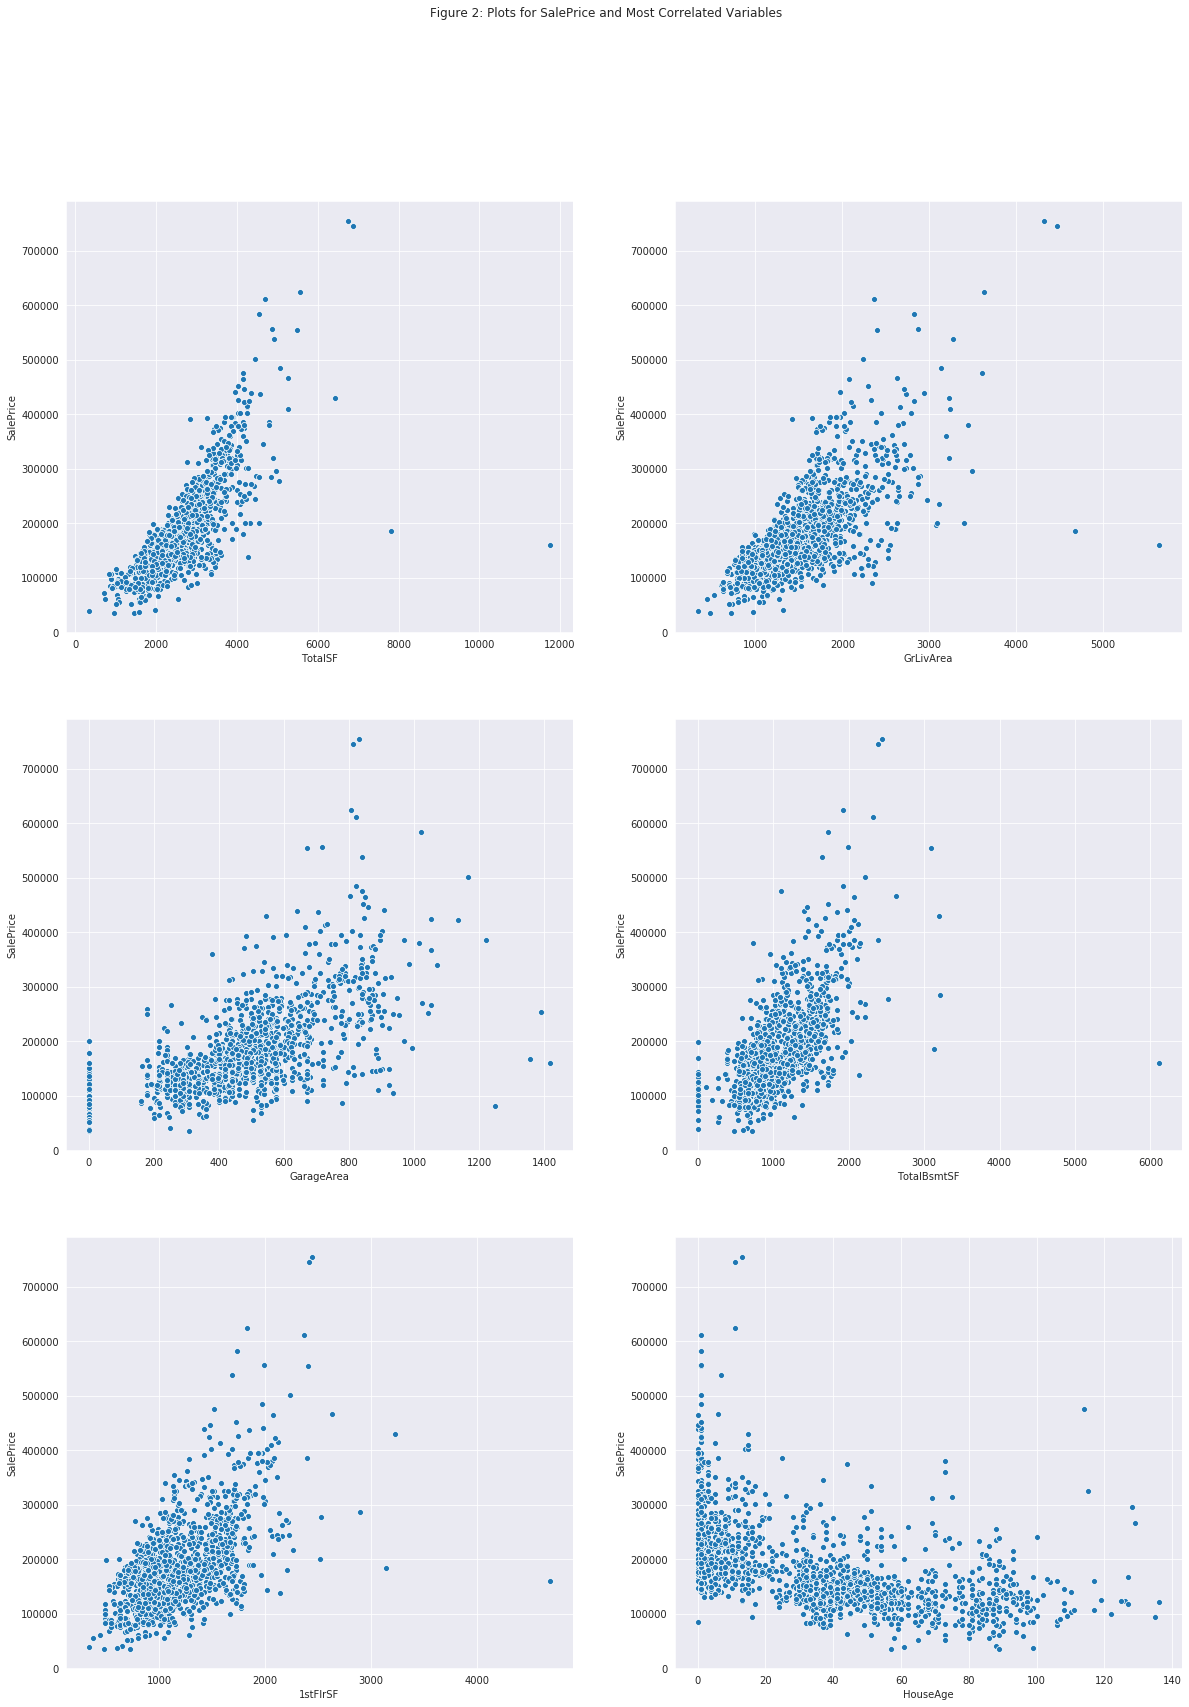

In [0]:
#Scatterplots
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 27))
sns.scatterplot('TotalSF', 'SalePrice', data = for_pairplot, ax = axs[0][0])
sns.scatterplot('GrLivArea', 'SalePrice', data = for_pairplot, ax = axs[0][1])
sns.scatterplot('GarageArea', 'SalePrice', data = for_pairplot, ax = axs[1][0])
sns.scatterplot('TotalBsmtSF', 'SalePrice', data = for_pairplot, ax = axs[1][1])
sns.scatterplot('1stFlrSF', 'SalePrice', data = for_pairplot, ax = axs[2][0])
sns.scatterplot('HouseAge', 'SalePrice', data = for_pairplot, ax = axs[2][1])
plt.suptitle('Figure 2: Plots for SalePrice and Most Correlated Variables')

A-ha! Some clear outliers. Luckily for us, the two furthest out in GrLivArea are also the outliers in 1stFlrSF, TotalBsmtSF, and TotalSF. There are five remaining in GarageArea: the three in the bottom right and the two at the very top. There are also three in HouseAge: one where a >100 year old house was sold for over $400,000, as well as the two most expensive overall (note that these don't look so far out-of-line in the other plots; that's the power of perspective). These last two overlap with the problem points in GarageArea.

Eight samples in more than fourteen-hundred is a loss of less than one percent, so we're dropping them. The rest of the data points on the edges are not decisive enough in my eyes, so they're staying

In [0]:
to_drop = [523, 1298, 581, 1190, 1061, 691, 1182, 185]
full_data = full_data.drop(to_drop)

#Checking Modeling Assumptions

1. Linear Relationships

This is what we're trying to establish: if linear models perform well on this data or not. We assume enough of a relationship for this whole project to not be a total waste of time.

2. Multivariate Normality

One of the assumptions of linear regression analysis is that of multivariate normality. That is, each variable must be normally distributed. We will be using some normalization techniques to transform what variables we can to ensure the best outcomes. For continuous numerical data this means log(x) or log(1+x) transformations (to account for 0s) ; for ordinal data we will be using min-max normalization; and for discrete numerical data we'll be standard score normalizing them. This last choice was somewhat arbitrary: as there is technically no upper limit to these variables, it seemed to make more sense than constraining them with min-max normalization.

Skewness
Skewness is a measure of assymetry in a distribution, with normal distributions having 0 skew. An absolute skewness of more than 0.5 can be said to be significantly skewed.

In [0]:
fd_skew = full_data.skew(axis = 0).sort_values(ascending = False)
fd_skew = fd_skew.drop(['MSSubClass', 'OverallQual', 'OverallCond',
                        'HouseAge', 'RemodAge'])
print(fd_skew)

MiscVal          21.938147
PoolArea         18.698520
LotArea          13.199131
LowQualFinSF     12.405435
3SsnPorch        11.365975
KitchenAbvGr      4.297648
BsmtFinSF2        4.141714
EnclosedPorch     3.999761
BsmtHalfBath      3.941716
ScreenPorch       3.930468
MasVnrArea        2.602911
OpenPorchSF       2.535199
WoodDeckSF        1.850580
1stFlrSF          1.256948
LotFrontage       1.050471
BsmtFinSF1        0.974911
GrLivArea         0.965693
TotalSF           0.938680
BsmtUnfSF         0.917775
2ndFlrSF          0.840811
TotRmsAbvGrd      0.743711
Fireplaces        0.727354
HalfBath          0.700151
TotalBsmtSF       0.662835
BsmtFullBath      0.622452
BedroomAbvGr      0.328769
GarageArea        0.167239
FullBath          0.160080
GarageCars       -0.224278
dtype: float64


Here we see our most skewed continuous numerical features, with no significant negative skew. This is nice, as negative skew must be transformed differently. Those with skewness > 0.5 will be log transformed

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0.5, 1.0, 'Figure 3: Distribution of SalePrice')

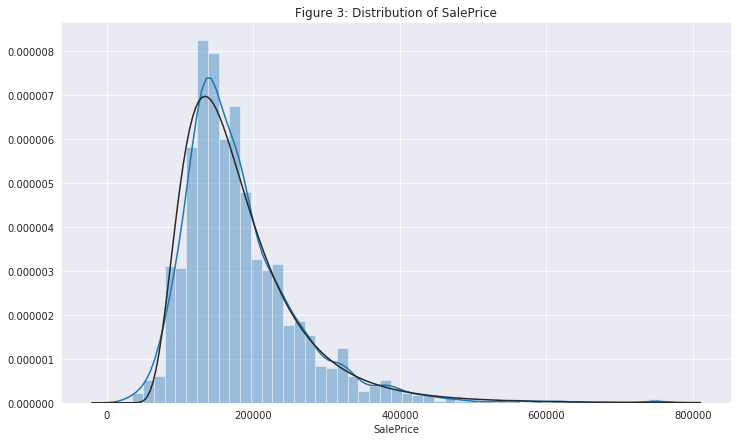

In [0]:
from scipy import stats
plt.figure(figsize = (12, 7))
sns.distplot(train.SalePrice, fit = stats.f).set_title('Figure 3: Distribution of SalePrice')

# Assumption 3: Multicollinearity
Our heatmap in figure 1 shows that there are no variables that are perfectly multicollinear (correlation of 1). There are some highly correlated variables, but feature selection in our regression models should be able to deal with this

# Autocorrelation and Homoscedasticity
We can check for autocorrelation (predicted observations not being independent from previous ones) and homoscedasticity (constant variance) with a graph of the residuals. For our purposes, we're only going to look at our most highly correlated variables from before



Text(0.5, 0.98, 'Figure 4: Residual Plots of Most Correlated Continuous Variables')

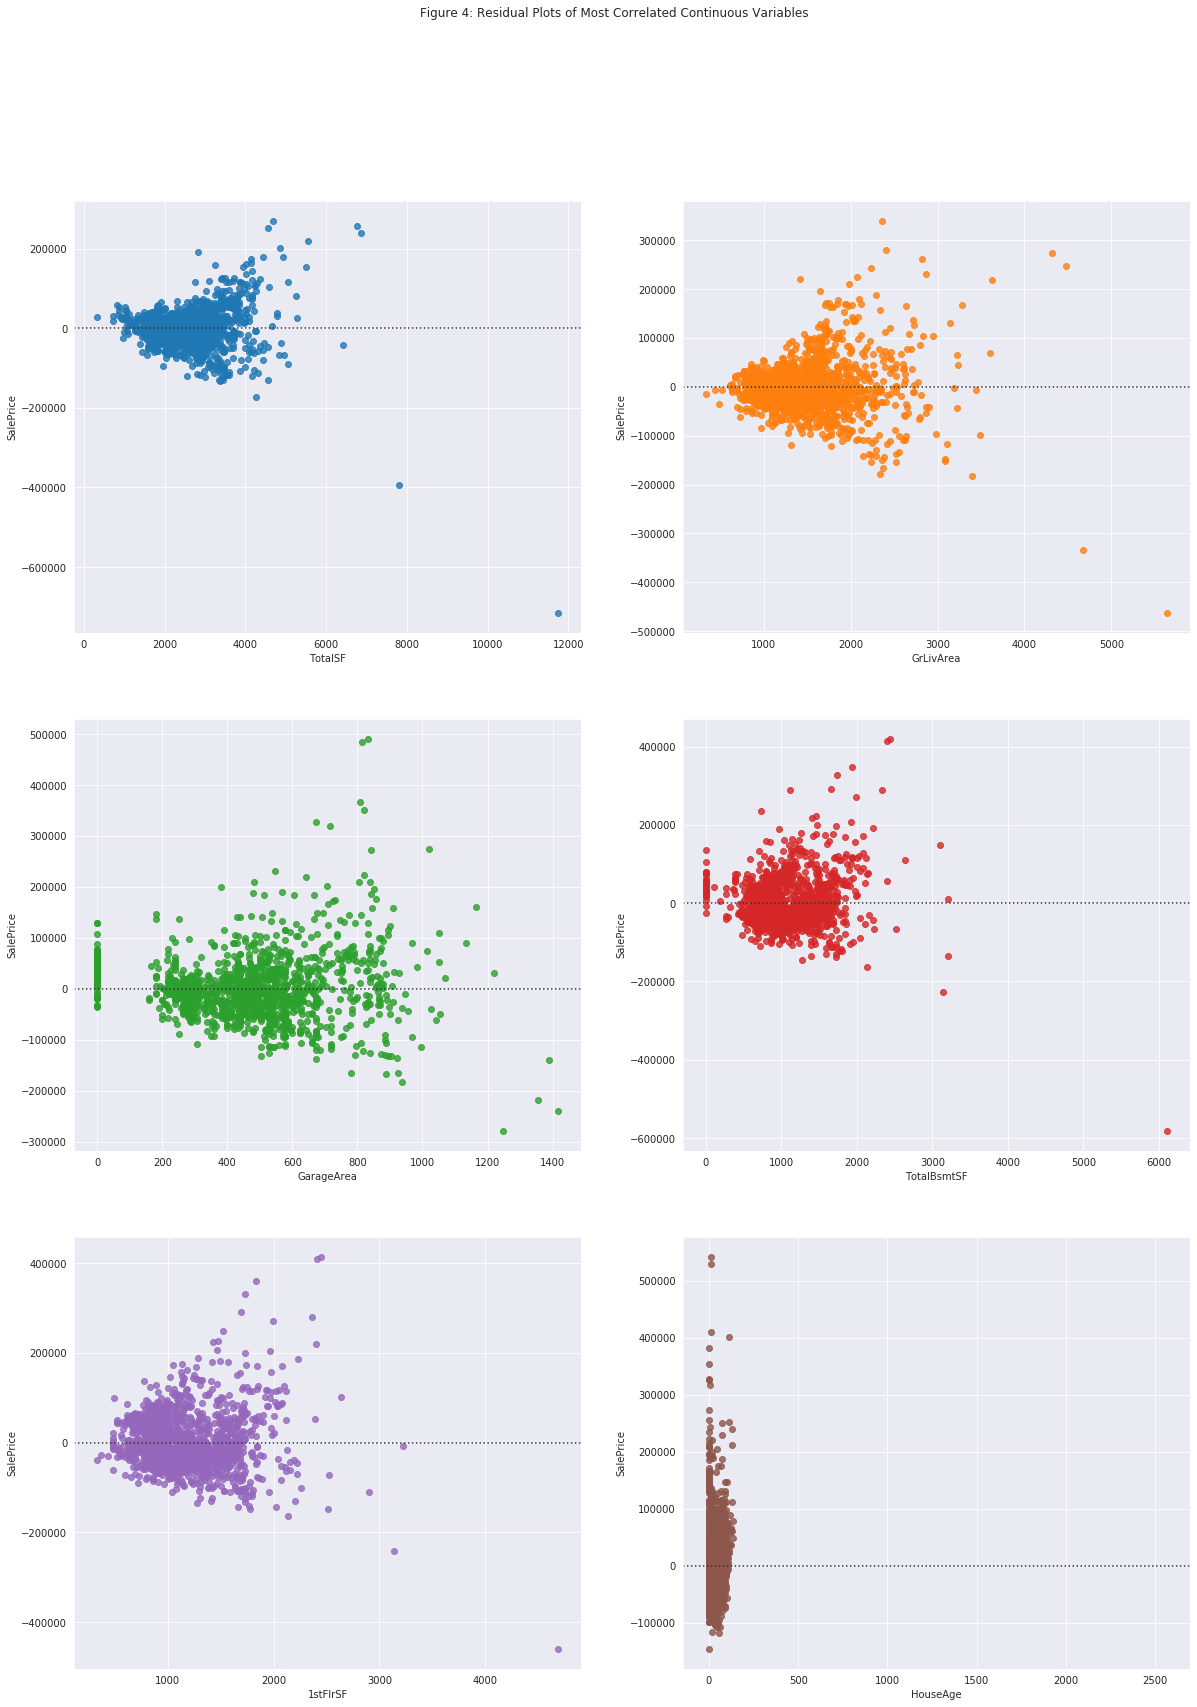

In [0]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 27))
sns.residplot('TotalSF', 'SalePrice', data = for_pairplot, ax = axs[0][0])
sns.residplot('GrLivArea', 'SalePrice', data = for_pairplot, ax = axs[0][1])
sns.residplot('GarageArea', 'SalePrice', data = for_pairplot, ax = axs[1][0])
sns.residplot('TotalBsmtSF', 'SalePrice', data = for_pairplot, ax = axs[1][1])
sns.residplot('1stFlrSF', 'SalePrice', data = for_pairplot, ax = axs[2][0])
sns.residplot('HouseAge', 'SalePrice', data = for_pairplot, ax = axs[2][1])
plt.suptitle('Figure 4: Residual Plots of Most Correlated Continuous Variables')

There does seem to be some measure of heteroscedasticity based on the slight "spray" patterns. The log transformation for skewness will also help correct this. Autocorrelation seems absent, which is what we want

#Transforming Numerical Data

Log Transformation

In [0]:
# adjust skewness with log(x+1)
skew_pos = fd_skew[fd_skew > 0.5].index
full_data[skew_pos] = full_data[skew_pos].transform(lambda x: np.log(x+1))

Z-Score Normalization

In [0]:
#create standard normal variables
to_z_score = ['HouseAge', 'RemodAge',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
              'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
              'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']
full_data[to_z_score] = full_data[to_z_score].transform(lambda x: (x - np.mean(x)) / np.std(x))

Ordinal Data

There is debate on how to handle ordinal data. It seems that the main contention is "How far apart are these values, really?" This is an excellent question. How far away, exactly, is a 9-quality house from a 10-quality? While we can say 9 is exactly 1 away from 10 on the number line, there is no answer to this question of quality: it is completely subjective.

Ordinal Independent Variables (Williams) makes the case that in practice is it generally fine to treat ordinal data as continuous. I'm going to heed this advice, as trying to handle it any other way in the context of this project may be impossible (for me, at the very least). What follows is the result of poring over the data and discerning what are likely ordinal variables as well as their classifications.

In [0]:
# Street, Alley
grav_map = {'NA' : 0, 'Grvl' : 1, 'Pave' : 2}
full_data[['Street', 'Alley']] = full_data[['Street', 'Alley']].replace(grav_map)

# LotShape 
shape_map = {'IR3' : 0, 'IR2' : 1, 'IR1' : 2, 'Reg' : 3}
full_data[['LotShape']] = full_data[['LotShape']].replace(shape_map)

# Utilities
util_map = {'ELO' : 0 , 'NoSeWa' : 1, 'NoSewr' : 2, 'AllPub' : 3}
full_data[['Utilities']] = full_data[['Utilities']].replace(util_map)

# LandSlope
slope_map = {'Sev' : 0, 'Mod' : 1, 'Gtl' : 2}
full_data[['LandSlope']] = full_data[['LandSlope']].replace(slope_map)

# HouseStyle
house_map = {'1Story' : 0, '1.5Unf' : 1, '1.5Fin' : 2, 'SFoyer' : 3, 'SLvl' : 4,
             '2Story' : 5, '2.5Unf' : 6, '2.5Fin' : 7} 
full_data[['HouseStyle']] = full_data[['HouseStyle']].replace(house_map)

# Quality
qual_map = {'NA' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}
by_qual = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
           'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
           'GarageCond', 'PoolQC']
full_data[by_qual] = full_data[by_qual].replace(qual_map)

# BsmtExposure
expo_map = {'NA' : 0, 'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4} 
full_data['BsmtExposure'] = full_data['BsmtExposure'].replace(expo_map)

#BsmtFinType1, 2
fin_map = {'NA' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5,
           'GLQ' : 6}
full_data[['BsmtFinType1', 'BsmtFinType2']] = full_data[['BsmtFinType1', 'BsmtFinType2']].replace(fin_map)

# Electrical
elec_map = {'FuseP' : 0, 'FuseF' : 1, 'Mix' : 2, 'FuseA' : 3, 'SBkr' : 4, 'SBrkr' : 4}
full_data['Electrical'] = full_data['Electrical'].replace(elec_map)

# CentralAir
bin_map = {'N' : 0, 'No' : 0, 'Y' : 1, 'Yes' : 1}
full_data['CentralAir'] = full_data['CentralAir'].replace(bin_map)

# Functional
func_map = {'Sal' : 0, 'Sev' : 1, 'Maj2' : 2, 'Maj1' : 3, 'Mod' : 4,
            'Min2' : 5, 'Min1' : 6, 'Typ' : 7}
full_data['Functional'] = full_data['Functional'].replace(func_map)

# GarageFinish
fing_map = {'NA' : 0, 'Unf' : 1, 'RFn' : 2, 'Fin' : 3} 
full_data['GarageFinish'] = full_data['GarageFinish'].replace(fing_map)

# PavedDrive
drive_map = {'N' : 0, 'P' : 1, 'Y' : 2} 
full_data['PavedDrive'] = full_data['PavedDrive'].replace(drive_map)

# Fence
fence_map = {'NA' : 0, 'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4}
full_data['Fence'] = full_data['Fence'].replace(fence_map)

In [0]:
# shift overallqual and cond
full_data[['OverallQual', 'OverallCond']] = full_data[['OverallQual', 'OverallCond']] - 1

#Transforming Ordinal Data
Min-Max Normalization

In [0]:
to_min_max = ['Street', 'Alley', 'LotShape', 'HouseStyle', 
              'Utilities', 'ExterQual', 'ExterCond', 'BsmtQual', 
              'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
              'GarageQual', 'GarageCond', 'PoolQC', 'BsmtExposure', 
              'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'CentralAir', 
              'Functional', 'GarageFinish', 'PavedDrive', 'Fence', 
              'OverallQual', 'OverallCond', 'LandSlope']

full_data[to_min_max] = full_data[to_min_max].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

#Categorical Variables and Dummies

Scikit-learn models unfortunately do not take factors as variables like R models do. To deal with this, we will create dummy variables. Also unfortunately, I found that pandas.get_dummies does not always operate as expected. As such, I had to construct a dummy dataframe from individually created dummy dataframes for each of the affected variables.

In [0]:
# for some reason did not convert type to int earlier
full_data.CentralAir = full_data.CentralAir.astype(int)

# manual dummies
dummies_mssub = pd.get_dummies(full_data.MSSubClass).add_prefix('MSSubClass_')
dummies_mszoning = pd.get_dummies(full_data.MSZoning).add_prefix('MSZoning_')
dummies_lcontour = pd.get_dummies(full_data.LandContour).add_prefix('LandContour_')
dummies_lconfig = pd.get_dummies(full_data.LotConfig).add_prefix('LotConfig_')
dummies_month = full_data.MoSold.str.get_dummies().add_prefix('MoSold_')
dummies_bldg = full_data.BldgType.str.get_dummies().add_prefix('BldgType_')
dummies_nbr = full_data.Neighborhood.str.get_dummies().add_prefix('Neighborhood_')
dummies_cond1 = full_data.Condition1.str.get_dummies().add_prefix('Cond1_')
dummies_cond2 = full_data.Condition2.str.get_dummies().add_prefix('Cond2_')
dummies_roofs = full_data.RoofStyle.str.get_dummies().add_prefix('RoofStyle_')
dummies_roofm = full_data.RoofMatl.str.get_dummies().add_prefix('RoofMatl_')
dummies_ext1 = full_data.Exterior1st.str.get_dummies().add_prefix('Ext1_')
dummies_ext2 = full_data.Exterior2nd.str.get_dummies().add_prefix('Ext2_')
dummies_mvt = full_data.MasVnrType.str.get_dummies().add_prefix('MasVnrType_')
dummies_found = full_data.Foundation.str.get_dummies().add_prefix('Foundaton_')
dummies_heat = full_data.Heating.str.get_dummies().add_prefix('Heating_')
dummies_gart = full_data.GarageType.str.get_dummies().add_prefix('GarageType_')
dummies_misc = full_data.MiscFeature.str.get_dummies().add_prefix('Misc_')
dummies_salet = full_data.SaleType.str.get_dummies().add_prefix('SaleType_')
dummies_salec = full_data.SaleCondition.str.get_dummies().add_prefix('SaleCond_')

# out with the old
drop_vars = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'MoSold',
             'BldgType', 'Neighborhood', 'Condition1', 'Condition2', 'RoofStyle',
             'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
             'Heating', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']

full_data_dropped = full_data.drop(columns = drop_vars)

# in with the new
full_data_dummies = pd.concat([full_data_dropped,
                               dummies_mssub,
                               dummies_mszoning,
                               dummies_lcontour,
                               dummies_lconfig,
                               dummies_month,
                               dummies_bldg,
                               dummies_nbr,
                               dummies_cond1,
                               dummies_cond2,
                               dummies_roofs,
                               dummies_roofm,
                               dummies_ext1,
                               dummies_ext2,
                               dummies_mvt,
                               dummies_found,
                               dummies_heat,
                               dummies_gart,
                               dummies_misc,
                               dummies_salet,
                               dummies_salec], axis = 1)

print(full_data_dummies.shape)

(2911, 238)


In [0]:
train.shape[0]

1460

#Reconstructing Train and Test Sets

In [0]:
train_clean = full_data_dummies[:(train.shape[0]-len(to_drop))] # len(to_drop)=8
test_clean = full_data_dummies[train_clean.shape[0]:]

print([train_clean.shape, test_clean.shape])

[(1452, 238), (1459, 238)]


#**Creating and Evaluating Models**
We're going to explore three kinds of linear regression models in the scikit-learn library: LASSO, Ridge, and ElasticNet. One advantage of each of these is that they employ a type of feature selection through weighting the variables so we don't have to incorporate dimensionality reduction into our preprocessing. Another is that linear models are more intrepretable than more complex methods like ensembles or neural networks, so they are easier to use for inference.

First, we need to create a function to score our models. We're going to manually compute it using the RMSE between the cross-validation predictions and the actual values. This will give us a good idea of the out-of-sample accuracy.

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from collections import namedtuple

def get_results(model, regr):
    # for error and prediction from model cross-validation
    ErrReturn = namedtuple('Output', 'Error Predictions')
    model.fit(regr, response)
    pred = cross_val_predict(model, regr, response, cv = 10)
    err = np.sqrt(mean_squared_error(pred, response))
    return ErrReturn(err, pred)

predictors = train_clean
response = np.log(train.SalePrice.drop(to_drop)) # was not transformed earlier, outliers dropped

I like LassoCV because it is much faster than GridSearchCV for parameter optimization. I kept my search relatively simple as you can seemingly spend your whole life optimizing an algorithm

**LASSO**

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
model_lasso_cv = LassoCV(alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                               0.1, 0.5, 1], max_iter = 50000, cv = 10)
model_lasso_cv.fit(predictors, response)
model_lasso = Lasso(alpha = model_lasso_cv.alpha_, max_iter = 50000)
results_lasso = get_results(model_lasso, predictors)

print(f"The RMSE for the LASSO model was {round(results_lasso.Error, 5)}")

The RMSE for the LASSO model was 0.10851


I borrowed most of the following code from Julien Cohen-Solal's A study on Regression applied to the Ames dataset as it is very useful and pretty

LASSO picked 93 features and eliminated the other 145 features


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

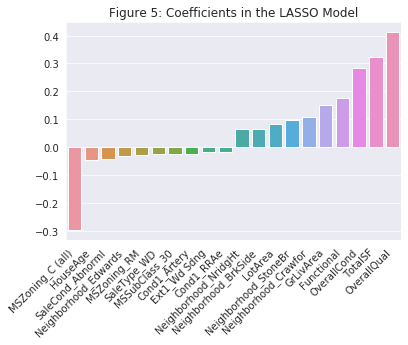

In [0]:
# Plot important coefficients
coefs = pd.Series(model_lasso.coef_, index = predictors.columns)
print(f"LASSO picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
sns.barplot(x = imp_coefs.index, y = imp_coefs)
plt.title("Figure 5: Coefficients in the LASSO Model")
plt.xticks(rotation = 45,
           horizontalalignment='right')

**Ridge Regression**

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
model_ridge_cv = RidgeCV(alphas = [0.0001, 0.001, 0.1, 1, 5, 10, 15, 20, 25, 30])
model_ridge_cv.fit(predictors, response)
model_ridge = Ridge(alpha = model_ridge_cv.alpha_)
results_ridge = get_results(model_ridge, predictors)

print(f"The RMSE for the Ridge model was {round(results_ridge.Error, 5)}")

The RMSE for the Ridge model was 0.11136


Ridge picked 234 features and eliminated the other 4 features


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

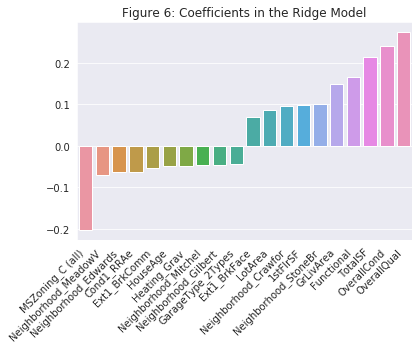

In [0]:
# Plot important coefficients
coefs = pd.Series(model_ridge.coef_, index = predictors.columns)
print(f"Ridge picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
sns.barplot(x = imp_coefs.index, y = imp_coefs)
plt.title("Figure 6: Coefficients in the Ridge Model")
plt.xticks(rotation = 45,
           horizontalalignment='right')

**Elastic Net**

In [0]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
model_en_cv = ElasticNetCV(l1_ratio = [.1, .3, .6, .9], max_iter = 50000,
                           alphas = [0.0001, 0.001, 0.1, 1, 5, 10, 15, 20, 25, 30],
                           fit_intercept = True, cv = 10)
model_en_cv.fit(predictors, response)
model_en = ElasticNet(l1_ratio = model_en_cv.l1_ratio_,
                           alpha = model_en_cv.alpha_,
                           max_iter = 50000,
                           fit_intercept = True,
                           random_state = 1)
results_en = get_results(model_en, predictors)
print(f"The RMSE for the ElasticNet model was {round(results_en.Error, 5)}")

The RMSE for the ElasticNet model was 0.1086


ElasticNet picked 118 features and eliminated the other 120 features


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

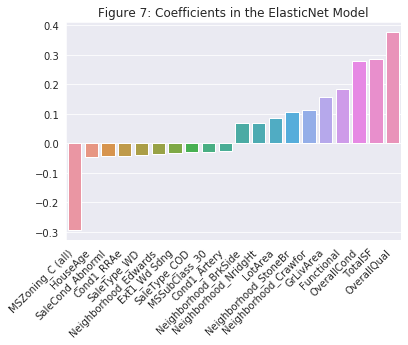

In [0]:
# Plot important coefficients
coefs = pd.Series(model_en.coef_, index = predictors.columns)
print(f"ElasticNet picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
sns.barplot(x = imp_coefs.index, y = imp_coefs)
plt.title("Figure 7: Coefficients in the ElasticNet Model")
plt.xticks(rotation = 45,
           horizontalalignment='right')

We see that ridge regression was the most conservative in terms of feature selection and it performed the worst, but only by a little. Really, they're all comparable

#**Conclusion**
Linear methods are a good choice for the Ames housing dataset if you take the time and adjust the data to something more usable. Anecdotally, after all the preprocessing, I found that other methods like XGB and GBR performed slightly worse than the techniques presented here. Before preprocessing they performed better, but still not as good as the models we have here. That goes to show the power of engineering your data toward your purposes.